In [1]:
import matplotlib.pyplot as plt
import cv2
from chart import show, show_collection
import numpy as np

In [2]:
img = cv2.imread("images/conceito.jpeg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
def channel_first(img):
    return [[[img[j][k][i] for k in range(len(img[0]))]
             for j in range(len(img))] for i in range(len(img[0][0]))]

def channel_last(img):
    return [[[img[k][i][j] for k in range(len(img))]
             for j in range(len(img[0][0]))] for i in range(len(img[0]))]
 
def electronic_wave_effect(img, strength=5, bgvalue=0):
    temp = channel_first(img)
    R = pad(channel_last([temp[0]]), (0, 2 * strength, 2 * strength, 0),
            bgvalue)

    G = pad(channel_last([temp[1]]), (strength, strength, strength, strength),
            bgvalue)

    B = pad(channel_last([temp[2]]), (2 * strength, 0, 0, 2 * strength),
            bgvalue)

    return channel_last(channel_first(R) + channel_first(G) + channel_first(B))

def pad(img, left_right_top_bottom, value=0):
    temp1 = img.copy()
    for i in range(left_right_top_bottom[2]):
        temp1.insert(0, [[value for i in range(len(temp1[0][0]))]
                         for i in range(len(temp1[0]))])
    for i in range(left_right_top_bottom[3]):
        temp1.insert(-1, [[value for i in range(len(temp1[0][0]))]
                          for i in range(len(temp1[0]))])
    temp1 = rotate_right(temp1)
    for i in range(left_right_top_bottom[0]):
        temp1.insert(0, [[value for i in range(len(temp1[0][0]))]
                         for i in range(len(temp1[0]))])
    for i in range(left_right_top_bottom[1]):
        temp1.insert(-1, [[value for i in range(len(temp1[0][0]))]
                          for i in range(len(temp1[0]))])
    temp1 = rotate_left(temp1)
    return temp1

def rotate_left(img):
    return [[[img[j][-1-i][k] for k in range(len(img[0][0]))]
             for j in range(len(img))] for i in range(len(img[0]))]

#rotate right
def rotate_right(img):
    return [[[img[-1 - j][i][k] for k in range(len(img[0][0]))]
             for j in range(len(img))] for i in range(len(img[0]))]

In [4]:
def add_list(img1, img2):
    return [[img1[i][j] + img2[i][j] for j in range(len(img1[0]))]
            for i in range(len(img1))]

In [38]:
def rgb_to_gray(img):
    return (img@[0.2989, 0.5870, 0.1140]).astype(np.uint()) # Transformação linear + Produto vetorial para a geração de um canal de cor

# Também pode ser escrito como
def rgb_to_gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.2989*r + 0.5870*g + 0.1140*b
    return gray

(168, 300)


<Figure size 1000x700 with 0 Axes>

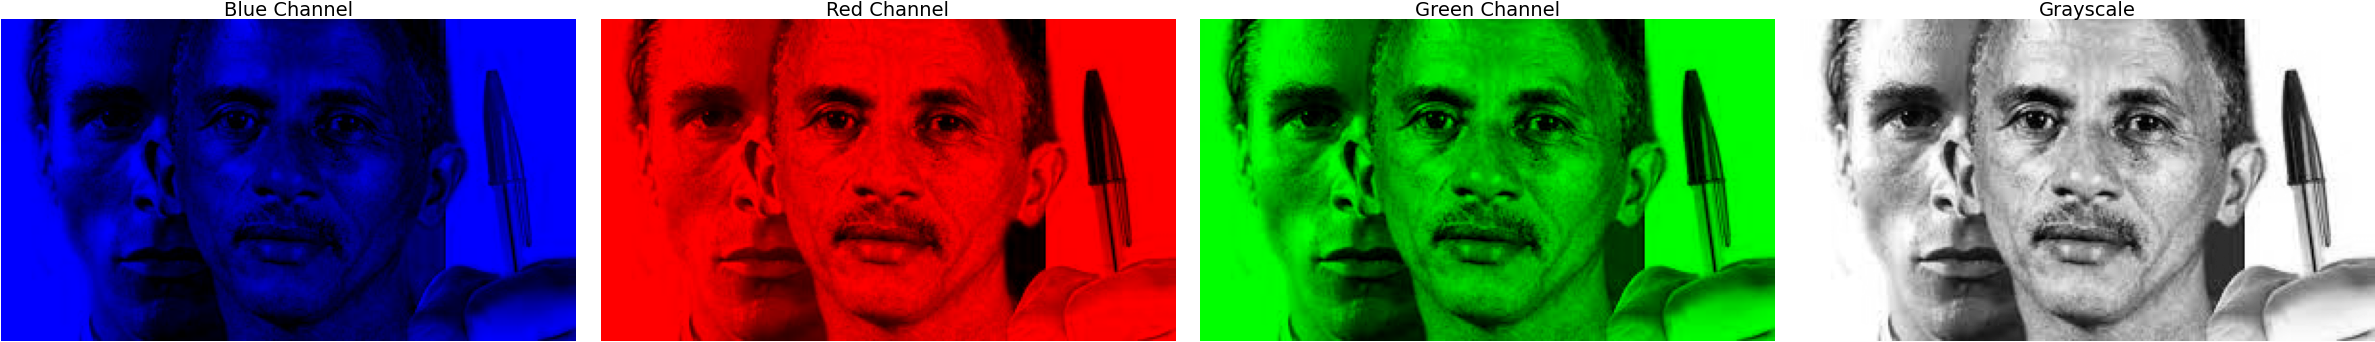

In [39]:
fig = plt.figure(figsize=(10, 7))

filtered_channels = []

for i in range(3):
    copia = img.copy()
    copia[:,:,i] = 0
    copia[:,:,(i+1)%3] = 0

    filtered_channels.append(copia)

filtered_channels.append(rgb_to_gray(img))
show_collection(filtered_channels, ["Blue Channel", "Red Channel", "Green Channel", "Grayscale"], fontsize=14, scale=0.2, cmap=plt.get_cmap("gray"))

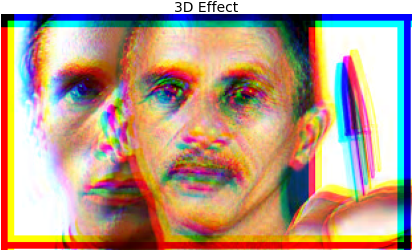

In [42]:
import numpy as np
show(np.array(electronic_wave_effect(img)), scale=0.3, title="3D Effect")

#### Testando diferentes aplicações de blur

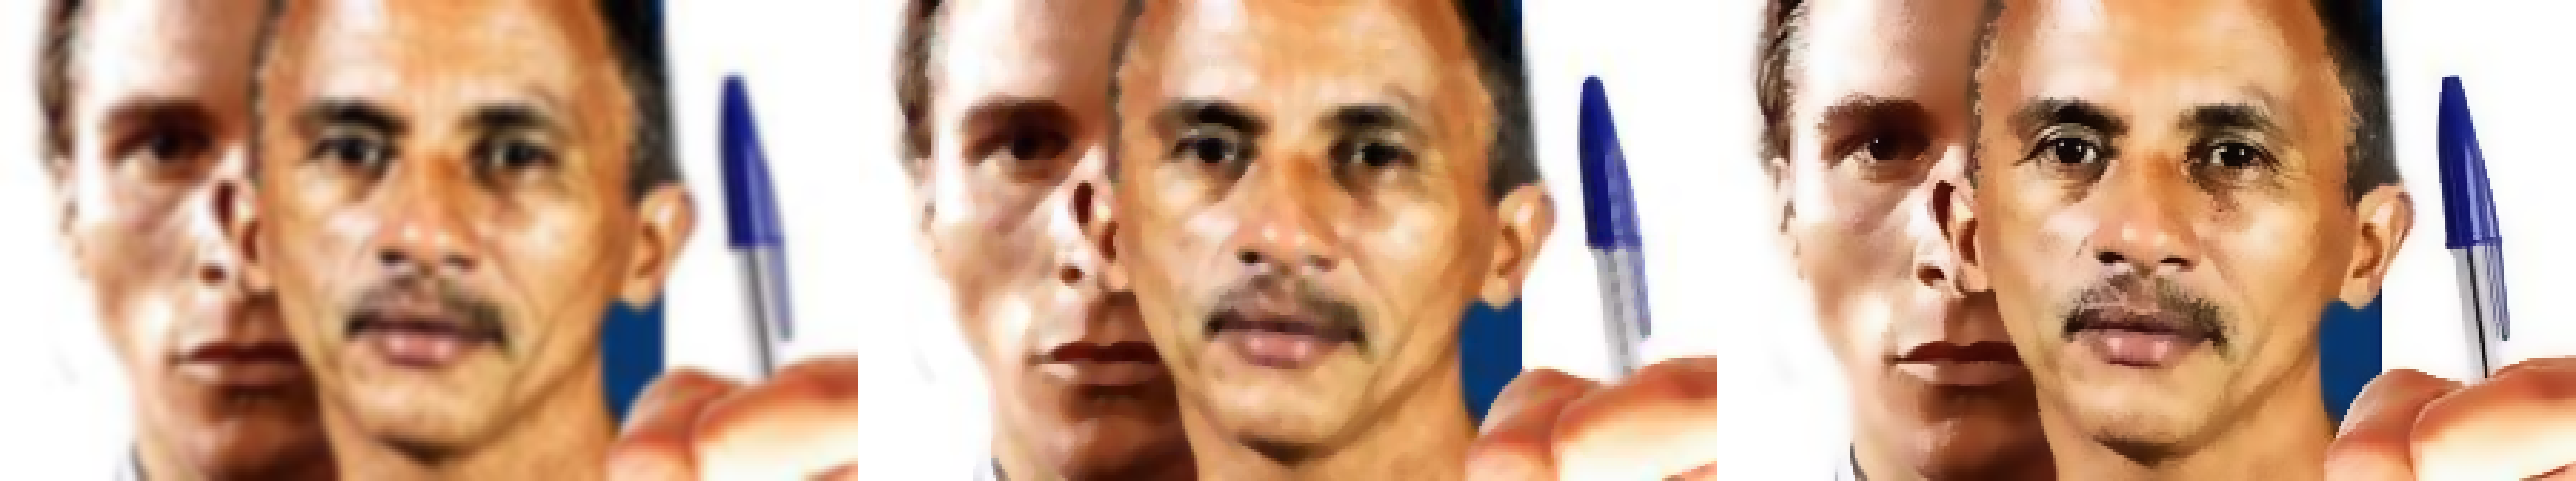

In [47]:
show_collection([cv2.GaussianBlur(img, (7, 7), 0), cv2.medianBlur(img, 5) , cv2.bilateralFilter(img, 9, 75, 75)])